QLearning使用表格估计Q函数,不便于扩展.

所以使用神经网络估计Q函数.

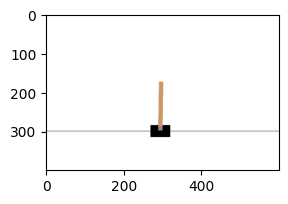

In [21]:
import gym
from typing import Tuple,Any

# 定义环境


class MyWrapper(gym.Wrapper):
    """
    自定义环境包装器类，继承自gym.Wrapper。
    """

    def __init__(self):
        """
        初始化方法。
        """
        env: gym.Env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env: gym.Env = env
        self.step_n: int = 0

    def reset(self)->Any:
        """
        重置环境状态。

        Returns:
            Tuple: 初始状态。
        """
        state, _ = self.env.reset()
        return state

    def step(self, action: int) -> Tuple:
        """
        执行动作并更新环境状态。

        Args:
            action (int): 动作。

        Returns:
            Tuple: 下一个状态、奖励、是否结束的标志。
        """
        state, reward, terminated, truncated, info = self.env.step(action)
        over: bool = terminated or truncated

        # 限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        # 没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    def show(self) -> None:
        """
        显示游戏图像。
        """
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [22]:
import torch

#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)
        data.append((state, action, reward, next_state, over))
        # print(state, action, reward, next_state)
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

e:\Miniconda3\envs\RL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-990.0

In [24]:
from typing import List, Tuple
import random
import torch

#数据池
class Pool:

    def __init__(self):
        self.pool: List[Tuple] = []

    def __len__(self) -> int:
        return len(self.pool)

    def __getitem__(self, i: int) -> Tuple:
        return self.pool[i]

    #更新动作池
    def update(self) -> None:
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(self.pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

(200,
 (array([ 0.04311174,  0.01471398, -0.04277565, -0.02047319], dtype=float32),
  1,
  1.0,
  array([ 0.04340602,  0.21042244, -0.04318511, -0.32633957], dtype=float32),
  False))

In [25]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 400 1.0
100 20000 1.0
200 20000 1.0
300 20000 1.0
400 20000 1.0
500 20000 1.0
600 20000 1.0
700 20000 1.0
800 20000 1.0


KeyboardInterrupt: 

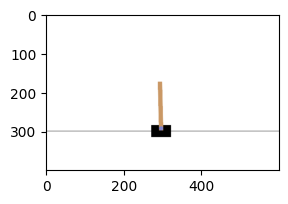

1.0

In [ ]:
play(True)[-1]